In [10]:
import import_ipynb
import prepareData

df_clean = prepareData.df_clean

df_clean

,customer_id,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,credit_limit,total_revolving_bal,active_customer
0,768805383,45,M,3,1,married,2,blue,39,5,12691.0,777,True
1,818770008,49,F,5,2,single,0,blue,44,6,8256.0,864,True
2,713982108,51,M,3,2,married,3,blue,36,4,3418.0,0,True
4,709106358,40,M,3,0,married,2,blue,21,5,4716.0,0,True
5,713061558,44,M,2,2,married,1,blue,36,3,4010.0,1247,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,710841183,54,M,1,1,single,2,blue,34,5,13940.0,2109,True
10121,713899383,56,F,1,2,single,0,blue,50,4,3688.0,606,True
10122,772366833,50,M,2,2,single,1,blue,40,3,4003.0,1851,True
10124,716506083,44,F,1,1,married,0,blue,36,5,5409.0,0,False


In [14]:
# Split data

from sklearn.model_selection import train_test_split

def split_dataFrame(df_to_split, y_column):
    df_full_train, df_test = train_test_split(df_to_split, test_size=0.2, random_state=11)
    df_train,  df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

    df_full_train = df_full_train.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_full_train = df_full_train[y_column]
    y_train = df_train[y_column]
    y_val = df_val[y_column]
    y_test = df_test[y_column]


    del df_full_train[y_column]
    del df_train[y_column]
    del df_val[y_column]
    del df_test[y_column]

    # with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    #     display(df_test)   

    print("df_to_split length: ", len(df_to_split))
    print()
    print("df_full_train length: ", len(df_full_train))
    print("df_train length: ", len(df_train))
    print("df_val length: ", len(df_val))
    print("df_test length: ", len(df_test))
    print()
    print("y_full_train length: ", len(y_full_train))
    print("y_train length: ", len(y_train))
    print("y_val length: ", len(y_val))
    print("y_test length: ", len(y_test))
    
    return df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test


In [22]:
y_column = "months_on_book"
train_columns = ["customer_age", "gender", "dependent_count", "education_level", "marital_status", "income_category", "card_category", "total_relationship_count", "credit_limit", "total_revolving_bal", "active_customer"]

df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test = split_dataFrame(df_clean[train_columns+[y_column]], y_column)
df_train


df_to_split length:  7081

df_full_train length:  5664
df_train length:  4248
df_val length:  1416
df_test length:  1417

y_full_train length:  5664
y_train length:  4248
y_val length:  1416
y_test length:  1417


,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,total_relationship_count,credit_limit,total_revolving_bal,active_customer
0,41,F,4,2,single,0,blue,5,1783.0,1282,True
1,51,M,2,0,married,2,blue,2,3559.0,0,True
2,47,M,5,1,married,3,blue,2,9410.0,0,False
3,53,M,2,2,married,2,blue,6,7928.0,1228,True
4,40,M,4,1,married,2,blue,6,5797.0,1779,True
...,...,...,...,...,...,...,...,...,...,...,...
4243,46,M,3,3,married,2,blue,3,13344.0,1907,False
4244,44,M,2,0,divorced,2,blue,6,3650.0,1270,True
4245,51,M,0,2,married,3,blue,4,7158.0,0,True
4246,48,F,3,3,divorced,1,blue,4,9336.0,1672,True


In [23]:
#Model training with XGboost

import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

def train(dataFrame, y, max_depth, eta):
    # Hot Encoding
    dicts = dataFrame.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    features = dv.get_feature_names()
    dtrain = xgb.DMatrix(X, label=y, feature_names=features)

    # train
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed':1,
        'verbosity':0
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    return dv, model

dv, model = train(df_train, y_train, 6, 0.3)

/Users/cristian.dugacicu/.local/share/virtualenvs/capstone-project-BLfaE_GI/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
def predict(dataFrame, dv, model):
    dicts = dataFrame.to_dict(orient="records")
    X = dv.transform(dicts)
    features = dv.get_feature_names()
    dval = xgb.DMatrix(X, feature_names=features)
    y_pred = model.predict(dval)
    return y_pred, X


y_pred_val, X_val = predict(df_val, dv, model)
y_pred_val

/Users/cristian.dugacicu/.local/share/virtualenvs/capstone-project-BLfaE_GI/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([46.913383, 37.344803, 33.95341 , ..., 37.124542, 48.199715,
       36.425205], dtype=float32)

In [34]:
# MAE, MSE, RMSE

from sklearn import metrics
import numpy as np
import pandas as pd

df_pred = pd.DataFrame(y_pred_val, columns=["predicted_months_on_book"])

mae = metrics.mean_absolute_error(y_val, y_pred_val)
mse = metrics.mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))

print("MAE for numerical linear:", mae)
print("MSE for numerical linear:", mse)
print("RMSE for numerical linear:", rmse)

MAE for numerical linear: 4.243355213585547
MSE for numerical linear: 27.43389092481349
RMSE for numerical linear: 5.237737195088495


Model max deviation +/-0.00: 0.000 percent
Model max deviation +/-1.00: 14.477 percent
Model max deviation +/-2.00: 28.460 percent
Model max deviation +/-3.00: 40.607 percent
Model max deviation +/-4.00: 53.814 percent
Model max deviation +/-5.00: 64.548 percent
Model max deviation +/-6.00: 74.929 percent
Model max deviation +/-7.00: 82.133 percent
Model max deviation +/-8.00: 88.277 percent
Model max deviation +/-9.00: 91.455 percent
Model max deviation +/-10.00: 94.774 percent
Model max deviation +/-11.00: 96.751 percent
Model max deviation +/-12.00: 98.093 percent
Model max deviation +/-13.00: 99.011 percent
Model max deviation +/-14.00: 99.223 percent
Model max deviation +/-15.00: 99.576 percent
Model max deviation +/-16.00: 99.859 percent
Model max deviation +/-17.00: 99.859 percent
Model max deviation +/-18.00: 99.929 percent
Model max deviation +/-19.00: 100.000 percent
Model max deviation +/-20.00: 100.000 percent


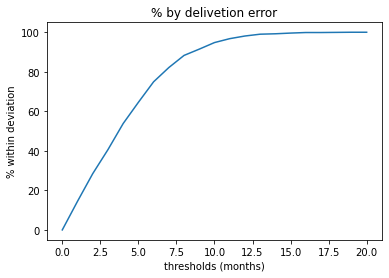

In [43]:
import matplotlib.pyplot as plt
from sklearn import metrics

thresholds = np.linspace(0, 20, 21)
y_count = len(df_pred.predicted_months_on_book)

scores = []
for t in thresholds:
    dev_within_t = (abs(y_pred_val-y_val) < t).sum()
    score = (dev_within_t*100)/y_count
    scores.append(score)
    print('Model max deviation +/-%.2f: %.3f percent' % (t, score))

plt.xlabel('thresholds (months)')
plt.ylabel('% within deviation')
plt.title('% by delivetion error')
plt.plot(thresholds, scores)